In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
reduce = 1

#%% obs grid
Nx, Ny = 30 // reduce, 30 // reduce
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 10
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [4]:
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

In [5]:
truepsffunc = gaussian_psf

In [36]:
Nsource = 20
np.random.seed(124)
xcenters = np.random.rand(Nsource)*Nx#(Nx-3)+1
ycenters = np.random.rand(Nsource)*Ny#(Ny-3)+1
truepsfkws = {"sigma": 1. / reduce}

In [37]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [38]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

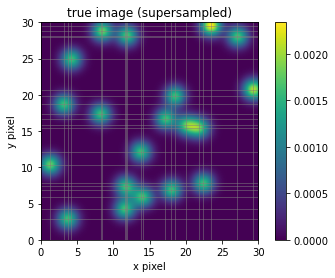

In [39]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

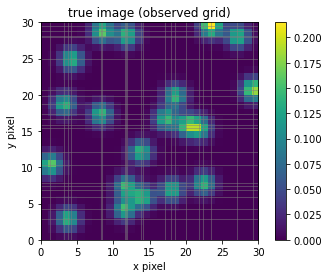

In [40]:
Z = super_to_obs(Zs)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [41]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

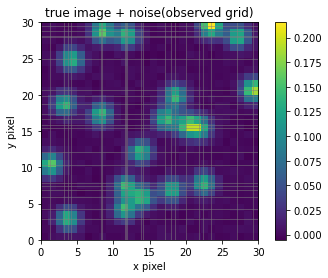

In [42]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise(observed grid)")

In [43]:
drx = pix.X1d[:,None] - xcenters
dry = pix.Y1d[:,None] - ycenters
dR2 = drx**2 + dry**2
staridx1d = jnp.argmin(dR2, axis=1)

In [44]:
def loglike(params, Z, sigmaerr):

    xc = jnp.r_[xcenters[0], params[:Nsource-1]]
    yc = jnp.r_[ycenters[0], params[Nsource-1:2*Nsource-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)

    drx = pix.X1d[:,None] - xc
    dry = pix.Y1d[:,None] - yc
    drx = jnp.diag(drx[:,staridx1d])
    dry = jnp.diag(dry[:,staridx1d])
    
    dx2 = jnp.power((drx[:,None]-drx[None,:]) / lenx, 2.0)
    dy2 = jnp.power((dry[:,None]-dry[None,:]) / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    kernel += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    numpyro.deterministic("kernel", kernel)
    
    mv = dist.MultivariateNormal(loc=0.0, covariance_matrix=kernel)    
    return mv.log_prob(Z.ravel())

objective = lambda p: -loglike(p, Zobs, sigmaerr)

In [45]:
width = 2.
shift = 0.
params = np.array(list(xcenters[1:]-1.*0.5) + list(ycenters[1:]+1.*0.5) + [0, 0, -5])
params_lower = list(xcenters[1:]-width) + list(ycenters[1:]-width) + [-2, -2, -10.]
params_upper = list(xcenters[1:]+width) + list(ycenters[1:]+width) + [2., 2., 0.]
bounds = (params_lower, params_upper)

In [46]:
def params_to_dict(params):
    dic = {}
    #c = params[:Nsource]
    xc = jnp.r_[xcenters[0], params[:Nsource-1]]
    yc = jnp.r_[ycenters[0], params[Nsource-1:2*Nsource-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    #dic['c'] = np.array(c)[1:]
    dic['x'] = np.array(xc)[1:]
    dic['y'] = np.array(yc)[1:]
    dic['lnlenx'] = float(lnlenx)
    dic['lnleny']= float(lnleny)
    dic['lna'] = float(lna)
    return dic

def show_res(res):
    print ()
    print (res)
    popt, state = res
    pdict = params_to_dict(popt)
    xmean = pdict['x']#[1:]
    ymean = pdict['y']#[1:]
    print (xmean, ymean)
    dx = xmean - xcenters[1:]
    dy = ymean - ycenters[1:]
    print ("# dx = %.3f +/- %.3f"%(np.mean(dx),np.std(dx)))
    print ("# dy = %.3f +/- %.3f"%(np.mean(dy),np.std(dy)))
    return popt, pdict

In [47]:
import jaxopt
method = "TNC"
solver = jaxopt.ScipyBoundedMinimize(fun=objective, method=method)

In [48]:
%%time
res = solver.run(params, bounds=bounds)
popt, pdict = show_res(res)


OptStep(params=DeviceArray([22.33002364, 17.33244522, 13.71940979, 11.69579314,
              8.20022496, 20.08272637, 11.71686562,  8.49118405,
             23.42410909, 17.94154553,  3.69130724, 11.80492339,
             29.18645802, 13.86075052,  4.20046554,  1.23485675,
             21.6749189 , 18.4346418 , 27.01859408,  7.78042971,
             16.6850494 , 12.13492647,  4.51852953, 17.30401009,
             15.72551818, 28.17853921, 28.76377035, 29.34585959,
              6.9100421 ,  2.92190633,  7.18539325, 20.70811839,
              5.94692404, 24.88083182, 10.38891445, 15.48927896,
             19.70556971, 28.01372989,  0.26223257,  0.31483403,
             -3.98536353], dtype=float64), state=ScipyMinimizeInfo(fun_val=DeviceArray(-227.62574147, dtype=float64), success=True, status=1, iter_num=17))
[22.33002364 17.33244522 13.71940979 11.69579314  8.20022496 20.08272637
 11.71686562  8.49118405 23.42410909 17.94154553  3.69130724 11.80492339
 29.18645802 13.86075052  4.2004

In [49]:
xmean = pdict['x']#[1:]
ymean = pdict['y']#[1:]
xstd, ystd = 0*xmean, 0*ymean
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
print (np.mean(xmean-xcenters[1:]), np.mean(ymean-ycenters[1:]))

-0.012187875251633106 -0.013752195732081652


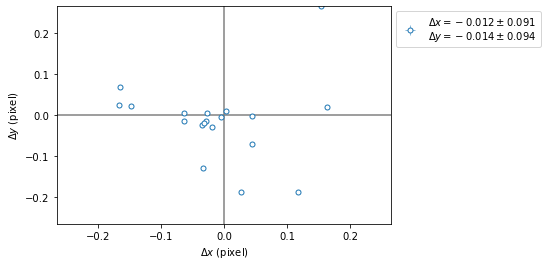

In [50]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))

In [51]:
from numpyro.infer import init_to_value
init_strategy = init_to_value(values=pdict)

In [52]:
def gpmodel(Z, sigmaerr, xcenters, ycenters):
    ones = jnp.ones_like(xcenters)
    
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-3, high=xcenters[1:]+3))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-3, high=ycenters[1:]+3))
    xc = jnp.r_[xcenters[0], x]
    yc = jnp.r_[ycenters[0], y]
   
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2+2, high=2))
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2+2, high=2))
    lna = numpyro.sample("lna", dist.Uniform(low=-10, high=0))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)

    drx = pix.X1d[:,None] - xc
    dry = pix.Y1d[:,None] - yc
    drx = jnp.diag(drx[:,staridx1d])
    dry = jnp.diag(dry[:,staridx1d])
    
    dx2 = jnp.power((drx[:,None]-drx[None,:]) / lenx, 2.0)
    dy2 = jnp.power((dry[:,None]-dry[None,:]) / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    kernel += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    numpyro.deterministic("kernel", kernel)
    
    mv = dist.MultivariateNormal(loc=0.0, covariance_matrix=kernel)    
    numpyro.sample("obs", mv, obs=Z.ravel())

In [54]:
kernel = numpyro.infer.NUTS(gpmodel, target_accept_prob=0.90, init_strategy=init_strategy)
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [55]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, Zobs, sigmaerr, xcenters, ycenters)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.75it/s, 31 steps of size 2.70e-01. acc. prob=0.93]


In [56]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       lna     -3.98      0.08     -3.99     -4.12     -3.85    421.72      1.00
    lnlenx      0.26      0.04      0.26      0.18      0.33    553.77      1.00
    lnleny      0.31      0.04      0.31      0.26      0.37    368.39      1.00
      x[0]     22.33      0.01     22.33     22.31     22.35    226.13      1.00
      x[1]     17.33      0.01     17.33     17.30     17.35    240.31      1.00
      x[2]     13.72      0.01     13.72     13.70     13.74    239.13      1.00
      x[3]     11.70      0.01     11.69     11.67     11.72    244.88      1.00
      x[4]      8.20      0.01      8.20      8.18      8.23    233.90      1.00
      x[5]     20.08      0.02     20.08     20.05     20.11    271.00      1.00
      x[6]     11.72      0.02     11.72     11.69     11.74    248.74      1.00
      x[7]      8.49      0.01      8.49      8.47      8.52    228.85      1.01
      x[8]     23.42      0

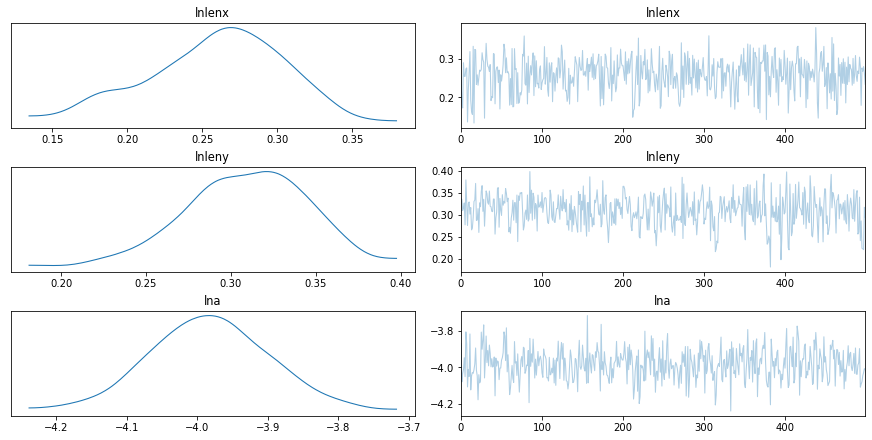

In [57]:
from arviz import plot_trace
fig = plot_trace(mcmc, var_names=['lnlenx', 'lnleny', 'lna'])

In [58]:
smp = mcmc.get_samples()

In [59]:
from numpyro.infer import Predictive
predictive = Predictive(gpmodel, mcmc.get_samples())
pred = predictive(random.PRNGKey(1), Z=Zobs, sigmaerr=sigmaerr, xcenters=xcenters, ycenters=ycenters)

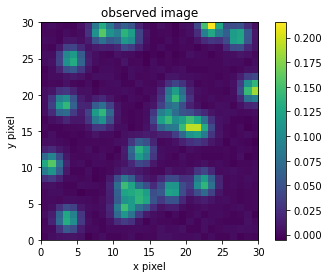

In [60]:
plot2d(Zobs, pix, title='observed image')

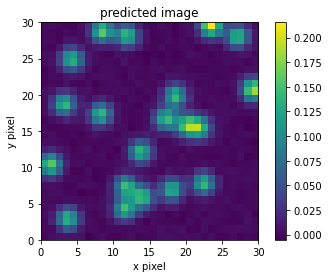

In [61]:
plot2d(np.mean(pred['obs'], axis=0).reshape(Nx,Ny), pix, title='predicted image')

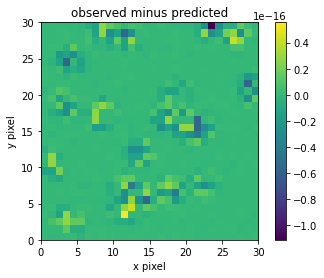

In [62]:
plot2d(Zobs-np.mean(pred['obs'], axis=0).reshape(Nx,Ny), pix, title='observed minus predicted')

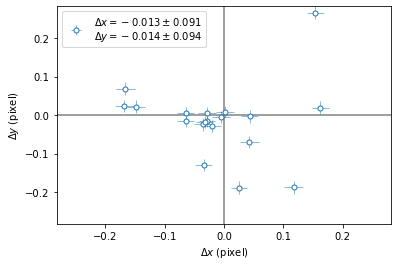

In [63]:
shift = 0
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0),np.std(smp['y'], axis=0)
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best')

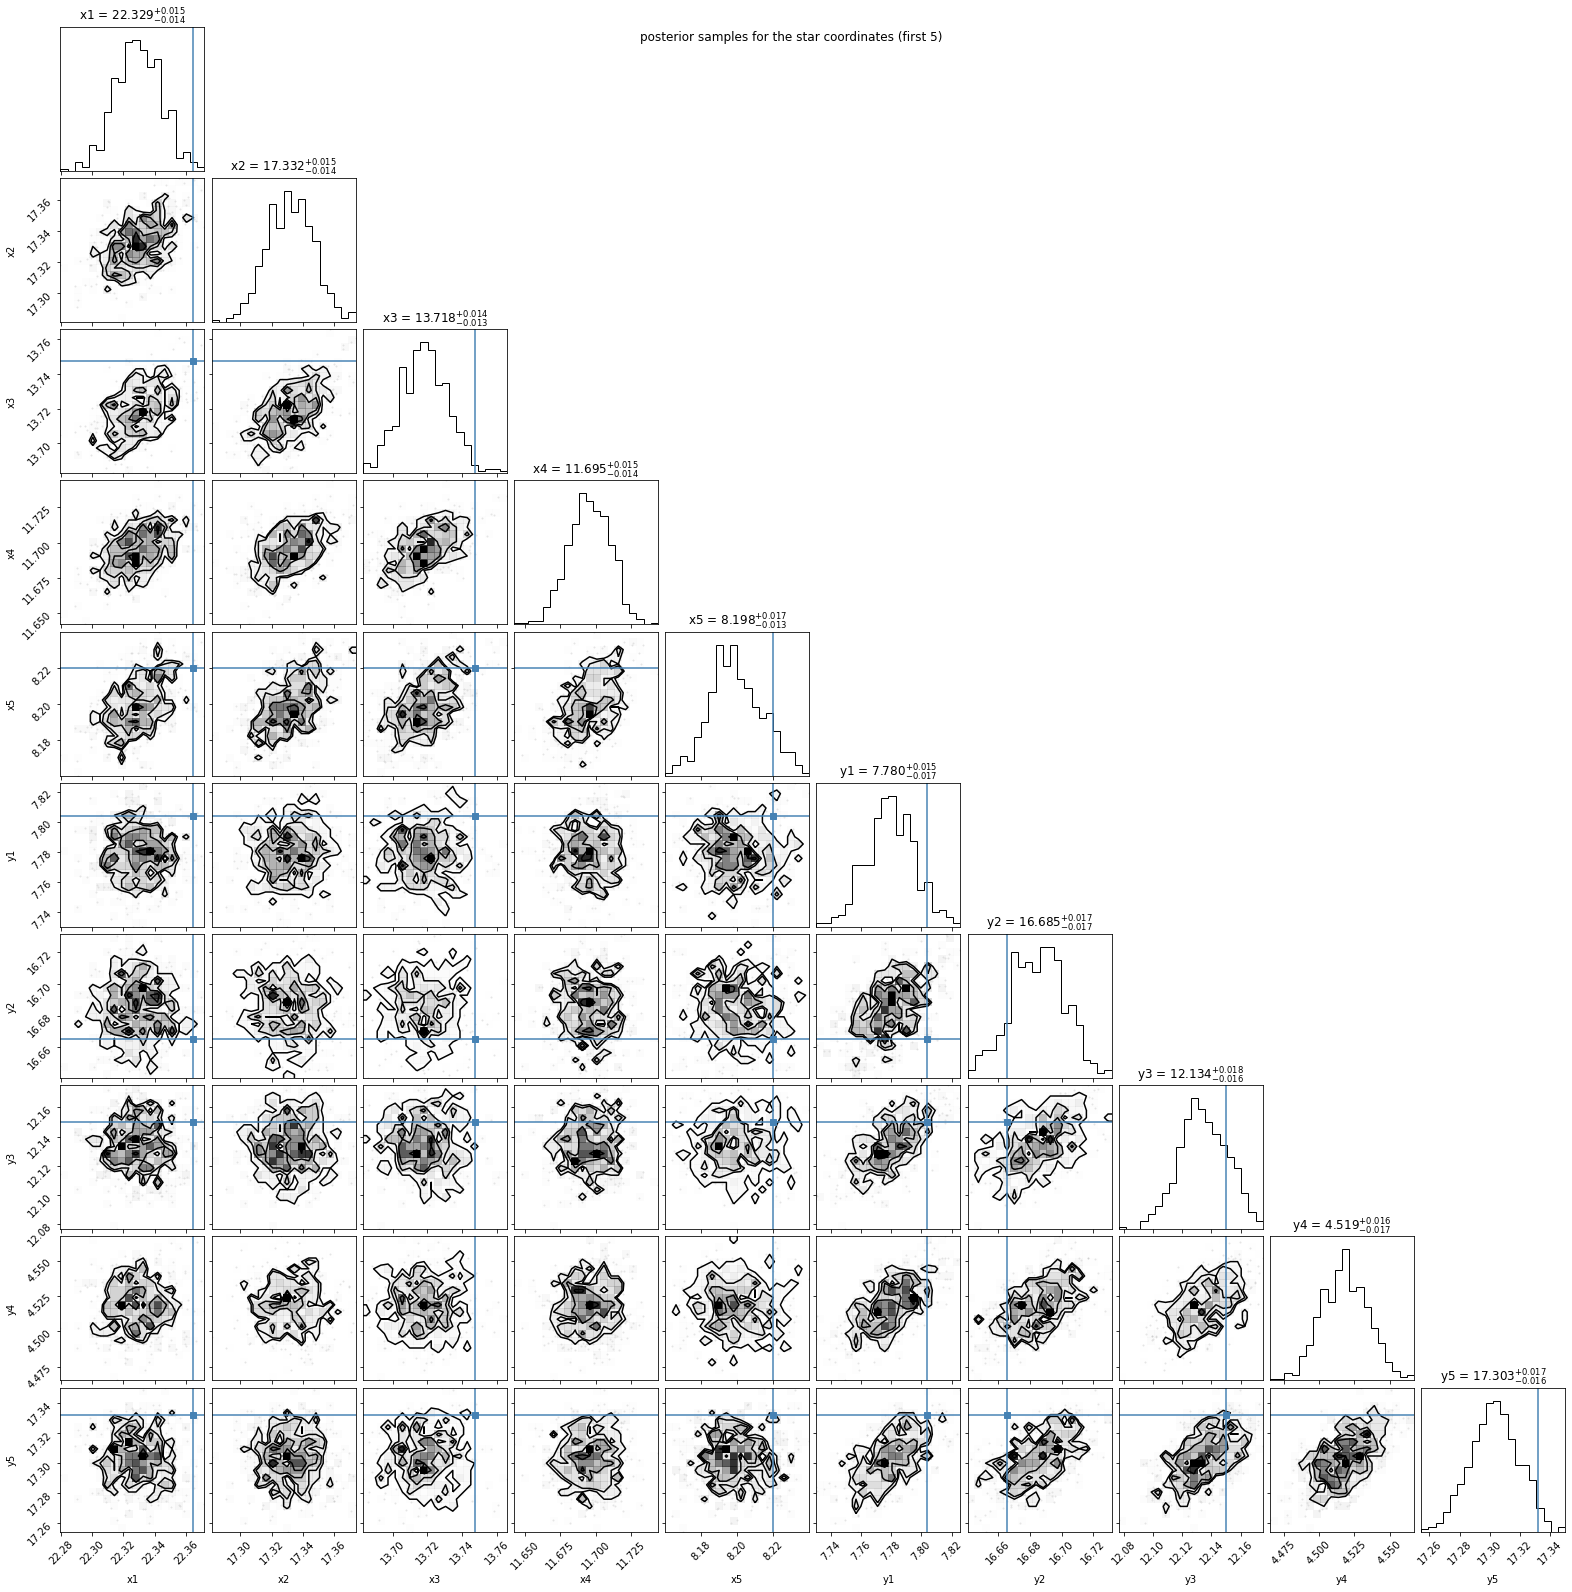

In [64]:
import corner
nplot = 5
fig = corner.corner(np.c_[np.array(smp['x'])[:,:nplot], np.array(smp['y'])[:,:nplot]], 
                    show_titles=True, title_fmt=".3f",
                    truths=np.r_[xcenters[1:][:nplot]+shift, ycenters[1:][:nplot]+shift],
                   labels=["x%d"%i for i in range(1,nplot+1)]+["y%d"%i for i in range(1,nplot+1)])
fig.suptitle("posterior samples for the star coordinates (first %d)"%nplot);

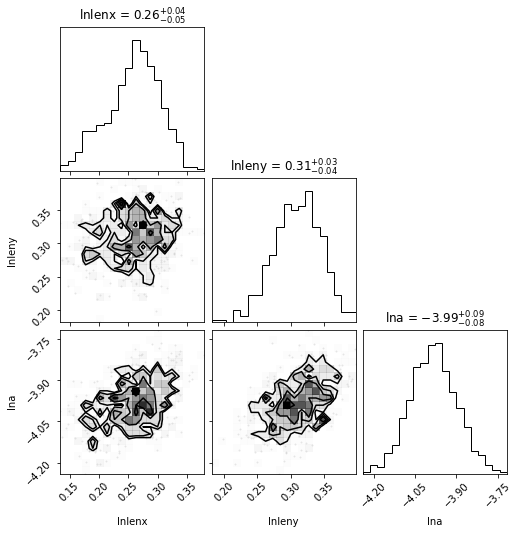

In [65]:
import pandas as pd
pnames = ["lnlenx", "lnleny", "lna"]
hyper = pd.DataFrame(data=dict(zip(pnames, [smp[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")